# 1: PyTorch Workflow

In [3]:
topics = {
    1: 'Data Preparation',
    2: 'Build Model',
    3: 'Fitting the Model to Data',
    4: 'Making Predictions and Evaluating the Model',
    5: 'Saving and Loading a Model',
    6: 'Putting it all together'
}

In [4]:
import torch
from torch import nn #nn contains building blocks for neural nets
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Data Preparation
* Get data into numerical representations
* Develop a model to learn the patterns in the numerical representations

In [6]:
#Create a linear regression formula to make a straight line with known parameters
weight = 0.7 #Slope
bias = 0.3 #Intercept

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Data Splitting into Training, Validation, and Test Sets

In [9]:
#Create a 80/20 train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

X_train.shape, y_train.shape, X_test.shape, y_train.shape

(torch.Size([40, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([40, 1]))

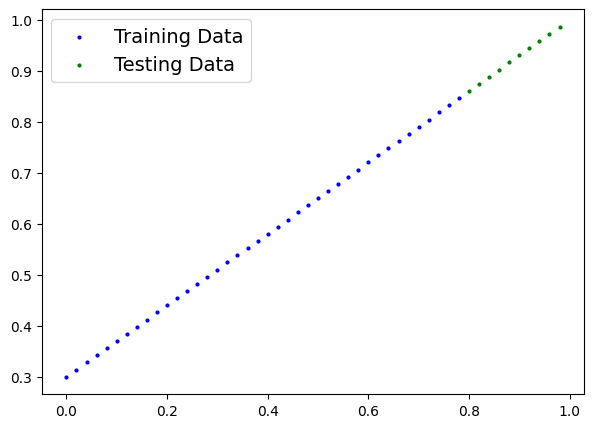

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    #Plots training data, test data, and compares predictions
    plt.figure(figsize = (7, 5))

    #Training Data
    plt.scatter(train_data, train_labels, c = 'b', s = 4, label = 'Training Data')

    #Test Data
    plt.scatter(test_data, test_labels, c = 'g', s = 4, label = 'Testing Data')

    #Are there predictions?
    if predictions is not None:
        plt.scatter(test_data, predictions, c = 'r', s = 4, label = 'Predictions')

    #Legend
    plt.legend(prop = {'size': 14})
plot_predictions()

### 2. Build the Linear Regression Model
What the model does:
* Start with random values for weight and bias
* Look at training data and adjust the random values to better represent the data

2 Main Algorithms:
1. Gradient Descent
2. Backpropagation

In [506]:
#Create linear regression model class
class LinearRegressionModel(nn.Module): #Class inherits from nn.Module which contains building blocks for neural nets
    def __init__(self):
        super().__init__()
        #Initialize the models parameters
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad = True, #Allows parameter to be updated through gradient descent
                                                dtype = torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad = True,
                                             dtype = torch.float))
        #Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: #x is the input data
        return self.weights * x + self.bias

### PyTorch Model Buidling Essentials
* torch.nn - contains all building blocks for computational graphs (like a neural nets)
* torch.nn.Parameter - what paramters the model should try to learn
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite the forward() function
* torch.optim - where optimizers live, they help with gradient descent
* def forward() - most overwrite it, this method defines what happens in the forward computation

### Checking contents of PyTorch Models
Check parameters using .parameters()

In [507]:
#Create a random seed
torch.manual_seed(42)

#Create an instance of the model 
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [508]:
#List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using torch.inference_mode()

How well can the model predict y_test using X_test.

When you pass data through the model, it runs through the forward method

In [509]:
#Make predictions with model
with torch.inference_mode(): #On inference mode, gradients are not tracked anymore which speeds up computations
    y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

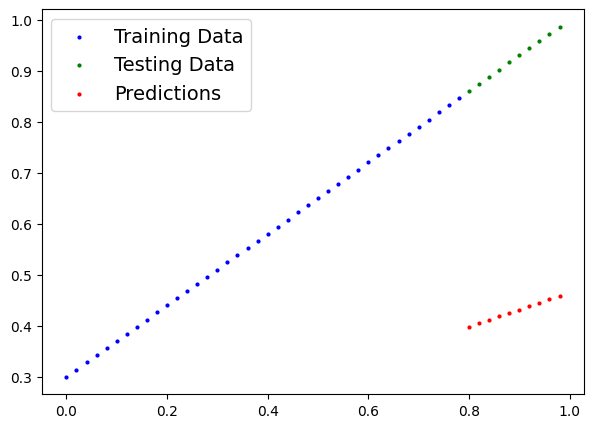

In [510]:
#Plot baseline predictions
plot_predictions(predictions = y_preds)

### 3. Train Model

Move the model from a poor representation of the data to a better representation of the data.

One way to predict how poor a models predictions are is using a loss function.

Things we need to train:
* Loss Function: Function to measure how wrong predictions are
* Optimizer: Adjusts model parameters to improve the loss function

In Pytorch, we need a traning loop and a testing loop

In [511]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [512]:
#Setup a loss function (L1 Loss / MAE)
loss_fn = nn.L1Loss()

#Setup an optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(
                            params = model_0.parameters(),
                            lr = 0.01, #Learning rate, most important hyperparameter
                            ) 

### 4. Building a Training and Testing Loop in PyTorch
0. Loop through the data
1. Forward pass (Data moving through the forward method(s))
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward - move backward through the network to calculate the gradients of each parameter with respect to the loss (**Backpropagation**)
5. Optimizer Step - use optimizer to adjust model parameters to try and improve the loss (**Gradient Descent**)

In [513]:
torch.manual_seed(42)
#An epoch is one loop through the data
epoch = 250

###Tracking values
epoch_count = []
loss_values = []
test_loss_values = []

###Training
#0. Loop through data
for epoch in range(epoch):
    #Set model to training mode
    model_0.train() #Set all parameters that require gradients to require gradients

    #1. Forward pass
    y_pred = model_0(X_train)

    #2. Calculate the loos
    loss = loss_fn(y_pred, y_train)

    #3. Optimizer Zero Grad
    optimizer.zero_grad() #Zeroes the optimizer

    #4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()

    #5. Step the optimizer (gradient descent)
    optimizer.step() #Optimizer changes accumulate through the loop so it has to be zeroed in step 3

    ###Testing
    model_0.eval() #Turns off setting in model not needed for testing
    with torch.inference_mode(): #Turns off gradient tracking
        #1. Forward pass
        test_pred = model_0(X_test)

        #2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch}, Loss: {loss}, Test Loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 0, Loss: 0.31288135051727295, Test Loss: 0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10, Loss: 0.1976713389158249, Test Loss: 0.3463551998138428
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20, Loss: 0.08908725529909134, Test Loss: 0.2172965705394745
OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})
Epoch: 30, Loss: 0.053148530423641205, Test Loss: 0.14464019238948822
OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})
Epoch: 40, Loss: 0.04543796554207802, Test Loss: 0.11360953748226166
OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})
Epoch: 50, Loss: 0.04167863354086876, Test Loss: 0.09919948130846024
OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 60, Loss: 0.03818932920694351, Test Loss: 0.08886633813381195
OrderedDict({'weights': tensor([0.5116]), 'bias': tensor([0.3788])})
Epoch: 70, Loss: 0.03476089984178543,

In [514]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

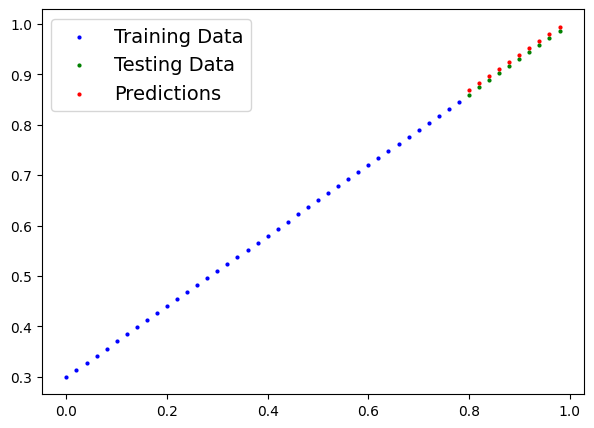

In [515]:
plot_predictions(predictions = y_preds_new)

In [516]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

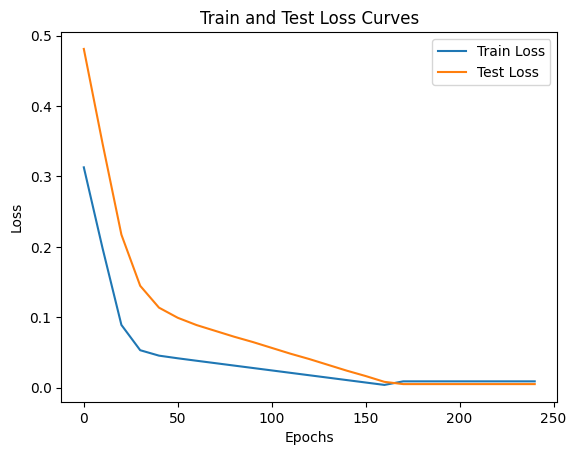

In [522]:
#Plot the loss curves
import numpy as np
plt.plot(torch.tensor(epoch_count).numpy(), torch.tensor(loss_values).numpy(), label = 'Train Loss')
plt.plot(torch.tensor(epoch_count).numpy(), torch.tensor(test_loss_values).numpy(), label = 'Test Loss')
plt.title('Train and Test Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### 5. Saving a Model in PyTorch
3 main functions to save and load models in PyTorch
1. `torch.save()` -> Saves the model in a Python pickle format
2. `torch.load()` -> Load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` -> Load a models saved state dictionary (parameters)

In [535]:
#Saving PyTorch model
from pathlib import Path

#Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

#Create a model save path
MODEL_NAME = '1_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#Save the model state dict
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

In [ ]:
#Load the model
loaded_model_0 = LinearRegressionModel()

#Load the saved state dict
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [539]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [540]:
#Make predictions with loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [541]:
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. Putting it All Together

In [620]:
import torch 
from torch import nn
import matplotlib.pyplot as plt

In [621]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [622]:
#Creating so data using y = weight * x + bias
weight = 0.7
bias = 0.4

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step)
y = weight * X + bias

In [623]:
#Split data
train_split = int(0.8 * len(X))
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)
y_train = y_train.unsqueeze(1)
y_test = y_test.unsqueeze(1)

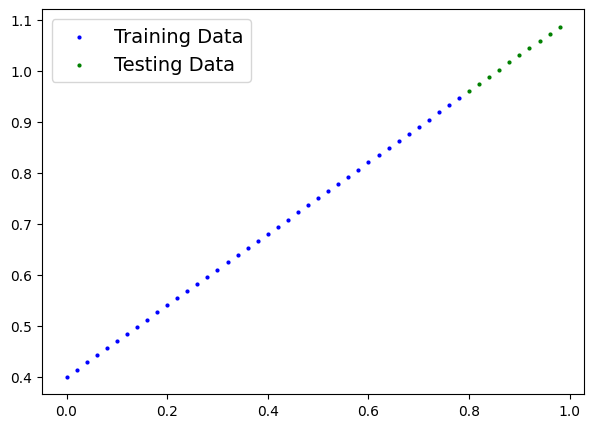

In [624]:
#Plot Data
plot_predictions(X_train, y_train, X_test, y_test)

In [625]:
#Building the linear model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        #Use nn.Linear() for creating parameters
        self.linear_layer = nn.Linear(in_features = 1, out_features = 1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [626]:
next(model_1.parameters()).device

device(type='cpu')

In [627]:
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

In [628]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(
    params = model_1.parameters(),
    lr = 0.01
    )

In [629]:
torch.manual_seed(42)

epochs = 200

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_pred = model_1(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}, Test Loss: {test_loss}")

Epoch: 0, Loss: 0.4551779329776764, Test Loss: 0.4739762246608734
Epoch: 20, Loss: 0.22475819289684296, Test Loss: 0.20455656945705414
Epoch: 40, Loss: 0.017893975600600243, Test Loss: 0.034524619579315186
Epoch: 60, Loss: 0.010405013337731361, Test Loss: 0.023519247770309448
Epoch: 80, Loss: 0.0035350986290723085, Test Loss: 0.007661056704819202
Epoch: 100, Loss: 0.006319505162537098, Test Loss: 0.009316968731582165
Epoch: 120, Loss: 0.006319505162537098, Test Loss: 0.009316968731582165
Epoch: 140, Loss: 0.006319505162537098, Test Loss: 0.009316968731582165
Epoch: 160, Loss: 0.006319505162537098, Test Loss: 0.009316968731582165
Epoch: 180, Loss: 0.006319505162537098, Test Loss: 0.009316968731582165


In [630]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6957]], device='mps:0')),
             ('linear_layer.bias', tensor([0.4080], device='mps:0'))])

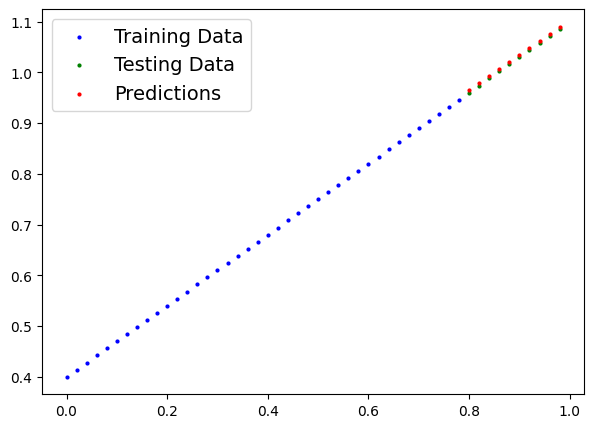

In [638]:
model_1.eval()
y_pred_new = model_1(X_test)
y_pred_new = y_pred_new.cpu().detach().numpy().squeeze()
X_train = X_train.cpu().detach().numpy()
X_test = X_test.cpu().detach().numpy()
y_train = y_train.cpu().detach().numpy()
y_test = y_test.cpu().detach().numpy()
plot_predictions(X_train, y_train, X_test, y_test, predictions = y_pred_new)

In [641]:
torch.save(model_1.state_dict(), 'models/1_model_1.pth')

In [642]:
loaded_model_1 = LinearRegressionModelV2()

loaded_model_1.load_state_dict(torch.load('models/1_model_1.pth'))

<All keys matched successfully>

In [644]:
loaded_model_1.eval()
y_loaded_preds = loaded_model_1(torch.from_numpy(X_test))

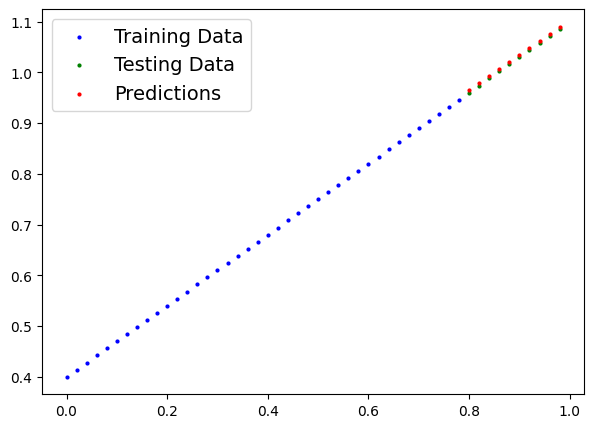

In [646]:
plot_predictions(X_train, y_train, X_test, y_test, predictions = y_loaded_preds.detach().numpy())